### Анализ данных центра клиентского сервиса


Ссылка на презентацию <a href = 'https://docs.google.com/presentation/d/11dCj69Wc3oUSRkPt4fHNAUYgX0hweVmExgvZ2ened5M/edit?usp=sharing'>здесь</a>

#### Цель


* проанализировать лояльность пользователей

* оценить возможный урон в недополученном количестве объявлений и пользователях

* при необходимости скорректировать критерии работы службы поддержки


#### Исходные данные


<b>support_tickets</b> таблица обращений в службу поддержки    
<b>users_evaluation_of_satisfaction</b> таблица с оценками пользователей их удовлетворенности после окончательного ответа сотрудника службы поддержки.  
<b>new_items_by_support_users</b> таблица с подачами объявлений  


#### Чтение данных

In [213]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, time

In [214]:
#формат отображения данных
matplotlib.rcParams['figure.figsize'] = (12,8)
plt.style.use('ggplot')
pd.options.display.max_rows = 150

In [215]:
current_dir = os.getcwd()
path = os.path.dirname(current_dir)
filenames = glob.glob(os.path.join(path, 'task', "*.csv")) 

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))
#filenames

In [216]:
sup_objects = dfs[0]
sup_tickets = dfs[1]
sup_evaluation = dfs[2]

дополнительные столбцы и формат данных:

In [217]:
# катекоризация подтем обращений: по объявлениям, по платным услугам
list_item = ['Автоматическая загрузка объявлений',
             'Блокировка или отклонение объявлений',
             'Заблокированное объявление',
             'Загрузка фото',
             'Не вижу свое оплаченное объявление',
             'Отклоненное объявление',
             'Ошибка при редактировании объявления',
             'Подача объявления',
             'Редактирование объявления',
             'Управление списками объявлений',
            ]

def tickets_item(item):
    if item in list_item:
        return 'ad'
    
sup_tickets['topic'] = sup_tickets['ticket_subcategory'].apply(tickets_item)

In [218]:
# формат данных
sup_objects['item_starttime'] = pd.to_datetime(sup_objects['item_starttime'])
sup_objects['user_registration_time'] = pd.to_datetime(sup_objects['user_registration_time'])

sup_tickets['activity_start_dt'] = pd.to_datetime(sup_tickets['activity_start_dt'])
sup_tickets['fact_reaction_dt'] = pd.to_datetime(sup_tickets['fact_reaction_dt'])

In [219]:
# доп.поле - время ответа на обращение
sup_tickets['time_answer'] = sup_tickets['fact_reaction_dt'] - sup_tickets['activity_start_dt']

In [220]:
sup_objects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18559923 entries, 0 to 18559922
Data columns (total 7 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   user_id                  object        
 1   user_registration_time   datetime64[ns]
 2   user_first_listing_date  object        
 3   item_id                  object        
 4   item_starttime           datetime64[ns]
 5   item_category            object        
 6   item_subcategory         object        
dtypes: datetime64[ns](2), object(5)
memory usage: 991.2+ MB


In [221]:
sup_tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397530 entries, 0 to 397529
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype          
---  ------              --------------   -----          
 0   user_id             397530 non-null  object         
 1   ticket_category     397530 non-null  object         
 2   ticket_subcategory  397530 non-null  object         
 3   current_state       397530 non-null  object         
 4   request_id          397530 non-null  object         
 5   activity_start_dt   397530 non-null  datetime64[ns] 
 6   fact_reaction_dt    397530 non-null  datetime64[ns] 
 7   topic               160350 non-null  object         
 8   time_answer         397530 non-null  timedelta64[ns]
dtypes: datetime64[ns](2), object(6), timedelta64[ns](1)
memory usage: 27.3+ MB


In [222]:
sup_evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217533 entries, 0 to 217532
Data columns (total 2 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   request_id                217414 non-null  object
 1   result_mentioned_by_user  217533 non-null  object
dtypes: object(2)
memory usage: 3.3+ MB


#### Oсновные показатели

In [223]:
# количество объявлений
sup_objects['user_id'].count()

18559923

In [224]:
# количество обращений
sup_tickets.shape[0]

397530

In [225]:
# пользователей обратилось в службу поддержки
sup_tickets.user_id.nunique()

298957

In [226]:
# количество пользователей, обратившихся по теме объявления
sup_tickets[sup_tickets['topic']=='ad']['user_id'].nunique()

107671

In [227]:
sup_evaluation.result_mentioned_by_user.count()

217533

In [228]:
# время последней активности пользователя: размещения объявления, обращения в службу поддержки
object_last = sup_objects.groupby('user_id')['item_starttime'].max().reset_index() # по объявлениям
ticket_last = sup_tickets.groupby(['user_id'])['activity_start_dt'].max().reset_index() # по обращениям
last = object_last.merge(ticket_last, left_on = 'user_id', right_on = 'user_id', how='left') 

In [229]:
# доп.столбец not_ad - пользователь не разместил НИ ОДНОГО объявления после последнего обращения
last.loc[last['activity_start_dt'] > last['item_starttime'], 'not_ad'] = 0
sup_tickets = sup_tickets.merge(last[['user_id', 'not_ad']], left_on = 'user_id', right_on = 'user_id', how='left')

In [230]:
# доп.столбцы - дата подачи объявления и обращения, в месяцах
sup_objects['item_starttime_month'] = sup_objects.item_starttime.apply(lambda x: str(x)[:7])
sup_tickets['activity_start_dt_month'] = sup_tickets.activity_start_dt.apply(lambda x: str(x)[:7])

In [231]:
sup_objects['item_starttime_month'] = pd.to_datetime(sup_objects['item_starttime_month'])

In [232]:
# выборка
sup_tickets_ad = sup_tickets[sup_tickets.topic == 'ad'] # обращений по теме объявления
sup_tickets_ad_object = sup_tickets_ad[sup_tickets_ad.not_ad != 0] # разместили объявление после обращения
sup_tickets_ad['user_id'].nunique() # пользователей обратилось по теме объявления

107671

In [233]:
# пользователи, обратившиеся по вопросу размещения объявления и не разместившие после ни одного
sup_tickets_ad[sup_tickets_ad['not_ad'] == 0].user_id.nunique()


20490

#### Уровень активности клиентов
Статистика по месяцам: сколько обратилось пользователей по теме объявлений, сколько разместили после обращения

In [234]:
# группировка данных по времени обращения, в месяцах
# по количеству пользователей, разместивших объявления
count_object_month = sup_tickets_ad_object.groupby('activity_start_dt_month')['user_id'].nunique().reset_index()
# по количеству пользователей, обратившихся по теме
count_ticket_month = sup_tickets_ad.groupby('activity_start_dt_month')['user_id'].nunique().reset_index()

In [235]:
count_object_month['activity_start_dt_month'] = pd.to_datetime(count_object_month['activity_start_dt_month'])
count_ticket_month['activity_start_dt_month'] = pd.to_datetime(count_ticket_month['activity_start_dt_month'])

In [236]:
count_month = count_object_month.merge(count_ticket_month, left_on = 'activity_start_dt_month', right_on = 'activity_start_dt_month', how = 'left' )

In [237]:
count_month = count_month[(count_month['activity_start_dt_month'] >= '2015-09') & (count_month['activity_start_dt_month'] < '2016-01')]

In [238]:
#формат данных
count_month['activity_start_dt_month'] = count_month['activity_start_dt_month'].dt.strftime('%Y-%m')
count_month['user_id_proc'] = round(count_month['user_id_x']/count_month['user_id_y']*100, 0)
count_month = count_month.reset_index(drop=True)

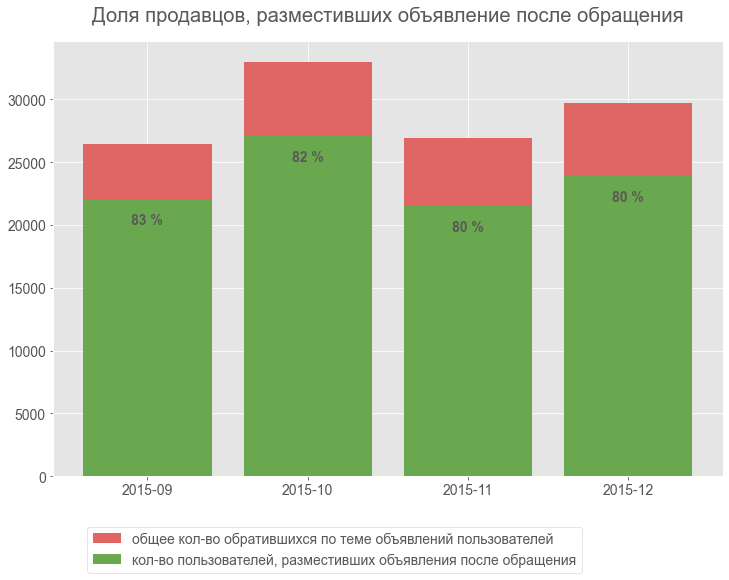

In [240]:
plt.rcParams['font.size'] = '14'
plt.rcParams['text.color'] = '#595959'
plt.rcParams['font.sans-serif'] = 'Arial'
width = 0.05
plt.bar(count_month.activity_start_dt_month, count_month.user_id_y, color = '#e06666', label='общее кол-во обратившихся по теме объявлений пользователей')
plt.bar(count_month.activity_start_dt_month, count_month.user_id_x, color = '#6aa84f', label='кол-во пользователей, разместивших объявления после обращения')

plt.title('Доля продавцов, разместивших объявление после обращения', pad=20)
plt.legend(bbox_to_anchor=(.8,-.1), facecolor='white', framealpha=1)

for i, v in enumerate(range(4)):
    plt.text(v-0.1, i+count_month.user_id_x[v]-2000, '{} %'.format(int(count_month.user_id_proc[v])), fontweight='bold')

#### Оценки пользователей

In [241]:
sup_tickets = sup_tickets.merge(sup_evaluation, left_on = 'request_id', right_on = 'request_id', how = 'left')

In [242]:
sup_tickets.result_mentioned_by_user.replace(np.nan, 'Без оценки', inplace=True)

In [243]:
# обращений всего, без оценки, с оценкой
print (sup_tickets.request_id.nunique(), 
sup_tickets[sup_tickets['result_mentioned_by_user'] == 'Без оценки'].request_id.nunique(),    
sup_tickets[sup_tickets['result_mentioned_by_user'] != 'Без оценки'].request_id.nunique(),
      )

397530 277108 120422


In [257]:
# количество обращений с результатом "неудовлетворительно" от тех, кто не разместил объявление
sup_tickets_not_ad_object = sup_tickets_ad[sup_tickets_ad['not_ad'] == 0]
sup_tickets_not_ad_object = sup_tickets_not_ad_object.merge(sup_evaluation, left_on = 'request_id', right_on = 'request_id', how = 'left')
sup_tickets_not_ad_object_neg = sup_tickets_not_ad_object.groupby('result_mentioned_by_user').request_id.nunique().reset_index()

In [261]:
sup_tickets_not_ad_object_neg, sup_tickets_not_ad_object_neg.request_id.sum()

(  result_mentioned_by_user  request_id
 0     Не удовлетворительно        2053
 1               Нейтрально         703
 2                  Отлично        2953
 3        Удовлетворительно         563
 4                   Хорошо        1136,
 7408)

In [263]:
# количество обращений
sup_tickets_count = sup_tickets.groupby('result_mentioned_by_user').request_id.nunique().reset_index()
sup_tickets_count 

,result_mentioned_by_user,request_id
0,Без оценки,277108
1,Не удовлетворительно,24510
2,Нейтрально,10578
3,Отлично,59750
4,Удовлетворительно,7029
5,Хорошо,18555


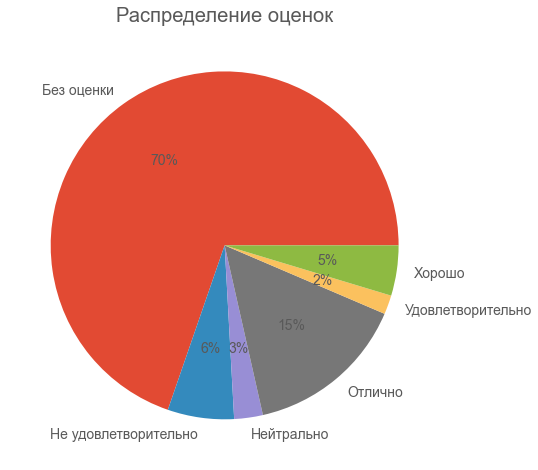

In [272]:
plt.pie(sup_tickets_count.request_id, labels = sup_tickets_count.result_mentioned_by_user, autopct='%1.0f%%')
plt.title('Распределение оценок')
plt.show()

In [277]:
sup_tickets[sup_tickets['result_mentioned_by_user'] != 'Без оценки'].groupby(['result_mentioned_by_user']).request_id.nunique(), sup_tickets[sup_tickets['result_mentioned_by_user'] != 'Без оценки'].groupby(['result_mentioned_by_user']).request_id.nunique().sum()

(result_mentioned_by_user
 Не удовлетворительно    24510
 Нейтрально              10578
 Отлично                 59750
 Удовлетворительно        7029
 Хорошо                  18555
 Name: request_id, dtype: int64,
 120422)

In [280]:
sup_tickets['result_mentioned_by_user'].value_counts(normalize=True).reset_index()

,index,result_mentioned_by_user
0,Без оценки,0.691311
1,Отлично,0.151538
2,Не удовлетворительно,0.064327
3,Хорошо,0.047270
4,Нейтрально,0.027190
5,Удовлетворительно,0.018364


In [283]:
#  время ответа по оценкам
sup_tick_eva = sup_tickets.merge(sup_evaluation, left_on='request_id', right_on='request_id', how='left')

In [284]:
sup_tick_eva['time_answer_hour'] = round(sup_tick_eva['time_answer']/np.timedelta64(1, "h"))

In [285]:
tick_eva_median = sup_tick_eva.groupby('result_mentioned_by_user_x')['time_answer_hour'].median(numeric_only=False).reset_index().sort_values(by = 'time_answer_hour', ascending=False)
tick_eva_median

,result_mentioned_by_user_x,time_answer_hour
4,Удовлетворительно,47.0
1,Не удовлетворительно,44.0
2,Нейтрально,41.0
5,Хорошо,30.0
3,Отлично,20.0
0,Без оценки,15.0


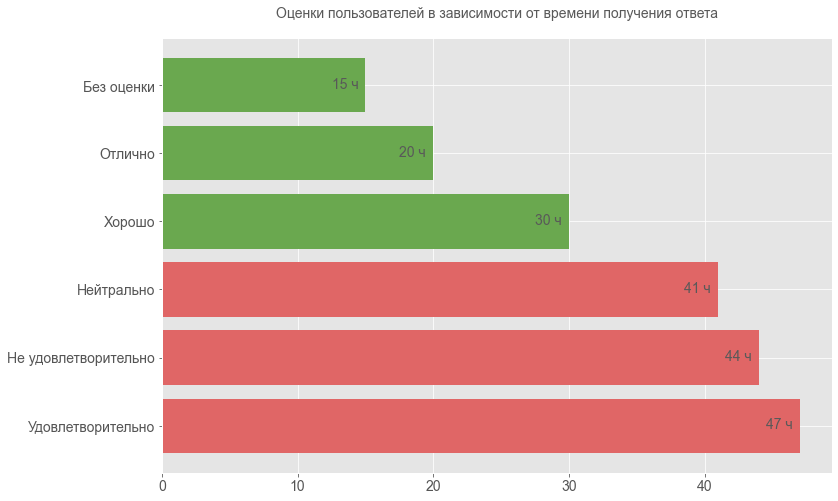

In [287]:
colors = ['#e06666', '#e06666', '#e06666', '#6aa84f', '#6aa84f', '#6aa84f']
width = 0.75
plt.rcParams['font.size'] = '14'
#plt.rcParams['font'] = 'Arial'
plt.barh(tick_eva_median.result_mentioned_by_user_x, tick_eva_median.time_answer_hour, color=colors)
plt.title('Оценки пользователей в зависимости от времени получения ответа', pad=20, color='#595959', font = 'Arial')
label = tick_eva_median.time_answer_hour
for i, v in enumerate(tick_eva_median.time_answer_hour):
    plt.text(v-2.5, i-.05, '{} ч'.format(int(v)), color='#595959', fontweight='bold', font = 'Arial')

#### Выводы: 

Согласно исследуемым данным, сайт теряет часть пользователей после обращения в службу поддержки:  
урон составляет примерно
20% (3,7 млн. объявлений и  50 тыс. пользователей)  
Также более 20% пользователей не удовлетворены результатом обращения в службу поддержки - необходимо сократить время ответа, проанализировать действия пользователей после обращения в службу поддержки.
